In [24]:
from typing import Set, Callable

from Ballot import Ballot
from CandidateModel import CandidateModel
from DefaultConfigOptions import *
from Election import Election
from ElectionResult import ElectionResult
from HeadToHeadElection import HeadToHeadElection
from InstantRunoffElection import InstantRunoffElection
from NDPopulation import NDPopulation

In [25]:
class ElectionConstructor:
    def __init__(self, constructor: Callable[[List[Ballot], Set[Candidate]], Election], name: str):
        self.constructor = constructor
        self.name = name

    def run(self, ballots: List[Ballot], candidates: Set[Candidate]) -> ElectionResult:
        e = self.constructor(ballots, candidates)
        return e.result()

def construct_irv(ballots: List[Ballot], candidates: Set[Candidate]):
    return InstantRunoffElection(ballots, candidates)

def construct_h2h(ballots: List[Ballot], candidates: Set[Candidate]):
    return HeadToHeadElection(ballots, candidates)

In [26]:
class Sample:
    def __init__(self, opponents: List[Candidate], candidate: Candidate):
        self.opponents = opponents.copy()
        self.candidate = candidate

In [27]:
def create_population(ideology_dim: int) -> (CandidateModel, NDPopulation):
    population_means = np.zeros(shape=(ideology_dim,))
    population_stddev = np.ones(shape=(ideology_dim,))
    pop = NDPopulation(population_means, population_stddev)
    return pop

In [28]:
class Stats:
    def __init__(self):
        self.winner_distance = 0
        self.results: List[Candidate] = []
    def reset(self):
        self.winner_distance = 0
        self.results = []
    def update(self, winner: Candidate):
        self.winner_distance += winner.ideology.distance_from_o()
        self.results += [winner]
    def print(self, label: str):
        print("%15s %5d " %
               (label,
               len(self.results)), end="")

        print("%5.2f" % (self.winner_distance / len(self.results)))

In [29]:
class ProcessResult:
    def __init__(self, process: ElectionConstructor, dim: int, stats: Stats):
        self.process = process
        self.dim = dim
        self.stats = stats

    def print(self):
        self.stats.print("%12s - %dD" % (self.process.name, self.dim))

In [30]:
def generate_candidates(population: NDPopulation, n_candidates: int) -> List[Candidate]:
    candidates = []
    for i in range(n_candidates):
        ideology = population.unit_sample_voter().ideology
        c = Candidate("r-" + str(i), Independents, ideology, 0)
        candidates += [c]
    return candidates

def run_process(processes: List[ElectionConstructor], dim: int, samples: int) -> List[ProcessResult]:
    results = {}
    for p in processes:
        results[p] = ProcessResult(p, dim, Stats())

    population = create_population(dim)
    for i in range(samples):
        voters = population.generate_unit_voters(100)
        candidates = generate_candidates(population, 6)
        for process in processes:
            ballots = [Ballot(v, candidates, unit_election_config) for v in voters]
            r = process.run(ballots, set(candidates))
            results[process].stats.update(r.winner())

    return list(results.values())

In [31]:
results = []
processes = [
    ElectionConstructor(constructor=construct_irv, name="Instant Runoff"),
    ElectionConstructor(constructor=construct_h2h, name="Head-to-Head")
]

for dim in [1,2,3,4]:
    results += run_process(processes, dim, 1000)

for r in results:
    r.print()

Instant Runoff - 1D  1000  0.64
Head-to-Head - 1D  1000  0.24
Instant Runoff - 2D  1000  0.94
Head-to-Head - 2D  1000  0.55
Instant Runoff - 3D  1000  1.23
Head-to-Head - 3D  1000  0.82
Instant Runoff - 4D  1000  1.51
Head-to-Head - 4D  1000  1.11


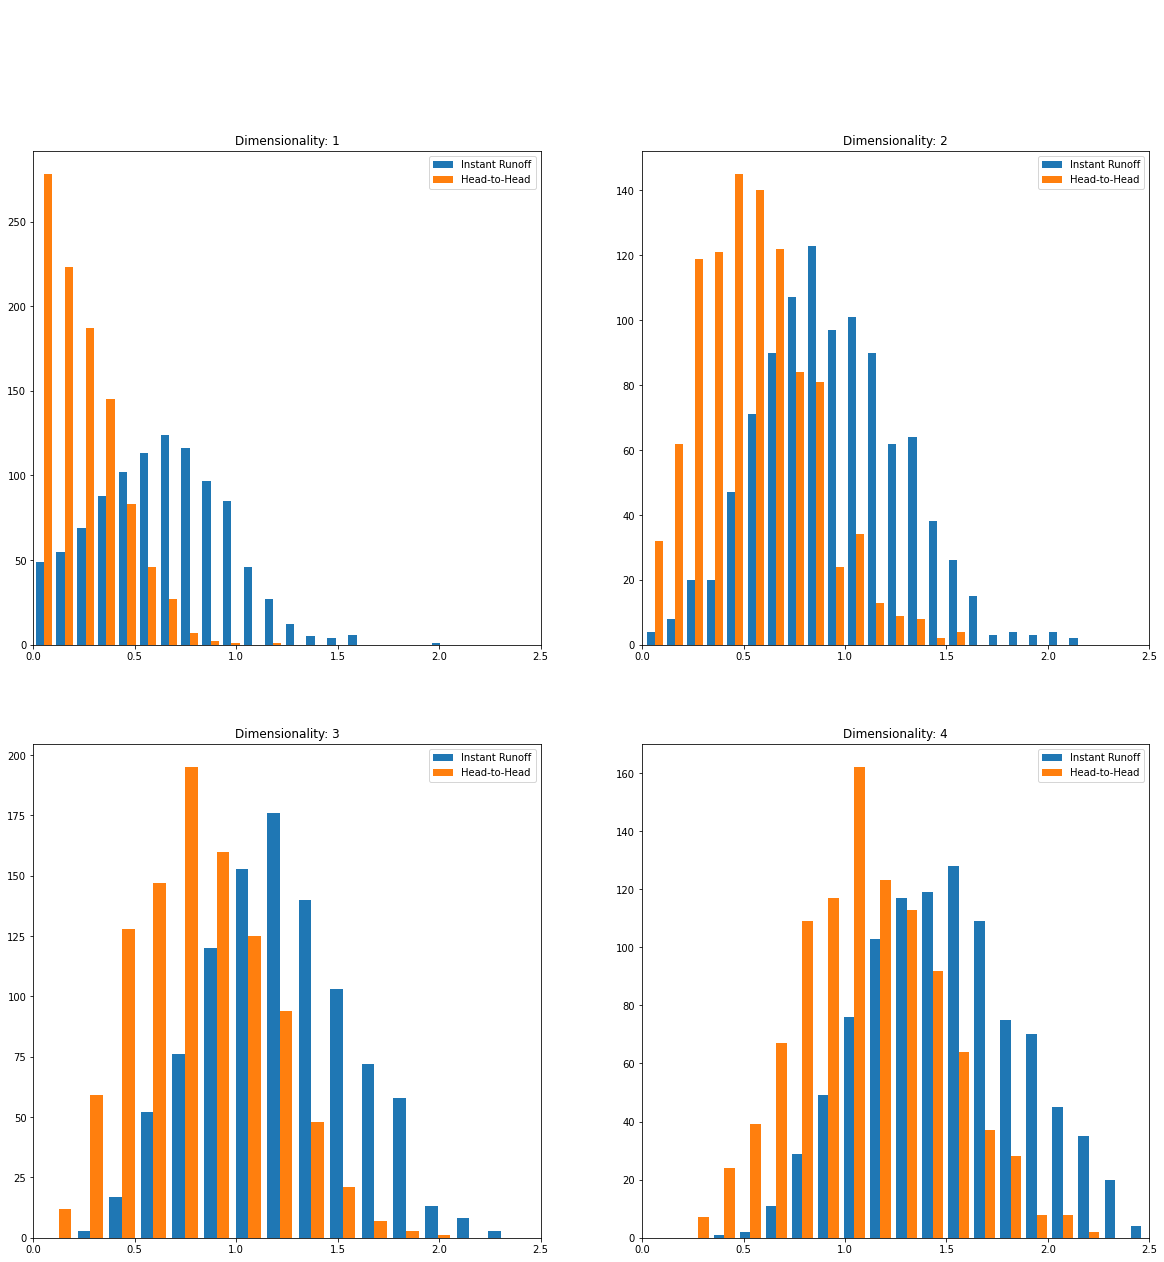

In [34]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
fig.suptitle("Random Candidates", color="white")

count = 0
irv_results = [r for r in results if r.process.name == "Instant Runoff"]
h2h_results = [r for r in results if r.process.name == "Head-to-Head"]

for ir, hr in zip(irv_results, h2h_results):
    assert(ir.dim == hr.dim)
    row = count // 2
    col = count % 2
    count += 1

    axis = axes[row][col]
    axis.tick_params(axis='x', colors="black")
    axis.tick_params(axis='y', colors="black")
    axis.set_xlim([0, 2.5])

    iv = [ w.ideology.distance_from_o() for w in ir.stats.results]
    hv = [ w.ideology.distance_from_o() for w in hr.stats.results]

    axis.hist([iv, hv], bins=30, label=[ir.process.name, hr.process.name])
    axis.set_title("Dimensionality: %d" % ir.dim, color="black")

    axis.legend()